#Libraries

In [ ]:
!pip list
!pip install tensorflow tensorflow-gpu opencv-python matplotlib
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
import os
import numpy as np
from tensorflow.keras.optimizers import SGD

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bi

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Data Preparation

In [ ]:
import zipfile
import os
import tensorflow as tf

# Define the path to the uploaded ZIP file
zip_file_path = "/content/Created Dataset-20240604T123219Z-001.zip"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

# After extraction, the directory name should be known.
# Assuming the directory name is 'Created Dataset' after extraction
data_path = "/content/Created Dataset"

# Load and preprocess the data
data = tf.keras.utils.image_dataset_from_directory(data_path, batch_size=32, image_size=(224, 224))
data = data.shuffle(buffer_size=1000, seed=42)
data = data.map(lambda x, y: (x / 255.0, y))  # Scale the pixel values to [0, 1]

# Split the data into training, validation, and test sets
dataset_size = len(data)
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.2)
test_size = dataset_size - train_size - val_size

# Use `take` and `skip` to split the dataset
train_data = data.take(train_size)
remaining = data.skip(train_size)
val_data = remaining.take(val_size)
test_data = remaining.skip(val_size).take(test_size)

# Verify the splits
print(f"Train data batches: {len(train_data)}")
print(f"Validation data batches: {len(val_data)}")
print(f"Test data batches: {len(test_data)}")


Found 999 files belonging to 3 classes.


##Data visulaization

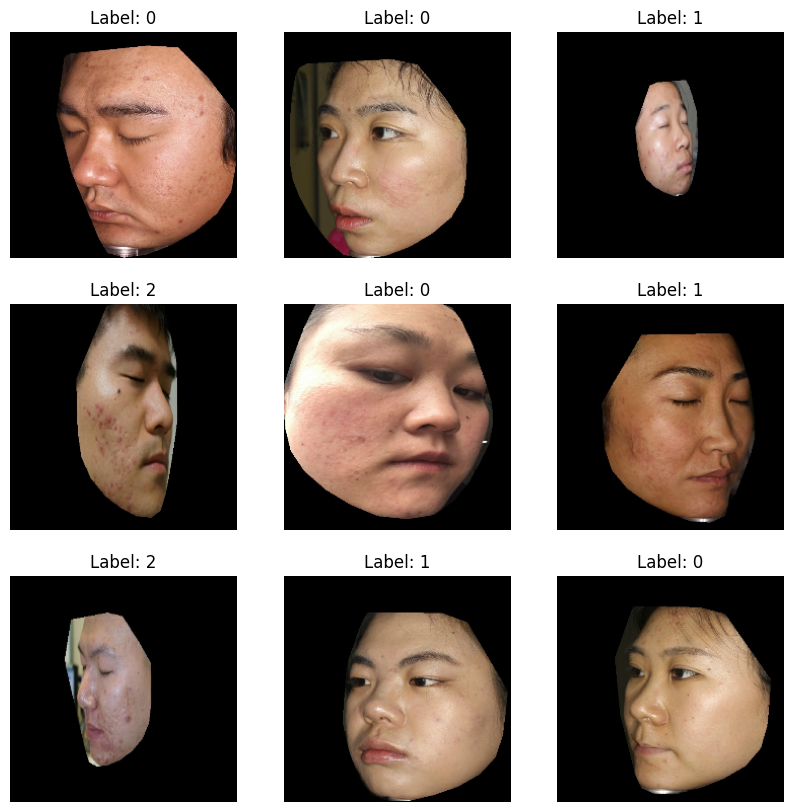

In [ ]:
# Initialize lists to store test data and labels
test_images = []
test_labels = []

# Iterate over the test dataset to extract data and labels
for image, label in test_data:
    test_images.append(image)
    test_labels.append(label)

# Concatenate the lists to get the complete test data and labels
test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)
import matplotlib.pyplot as plt

# Iterate over the dataset and display a few examples
for images, labels in train_data.take(1):  # Taking one batch for demonstration
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Displaying 9 images from the batch
        ax = plt.subplot(3, 3, i + 1)
        # Ensure correct scaling and data type
        image = (images[i] * 255).numpy().astype("uint8")
        plt.imshow(image)
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

#Model building and training

In [ ]:
def create_model1(base_model, activation='softmax'):
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(3, activation=activation)(x)  # 3 classes for acne severity
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model2(base_model, activation='softmax'):
    # Add more layers or change layer configurations
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)  # Additional dense layer
    x = Dense(128, activation='relu')(x)  # Additional dense layer
    output = Dense(3, activation=activation)(x)

    # Change optimizer or learning rate
    optimizer = SGD(learning_rate=0.01, momentum=0.9)  # Use SGD optimizer with different learning rate and momentum
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
%%time
# Train the base models separately
base_model1 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model1 = create_model1(base_model1)
history1 = model1.fit(train_data, validation_data=val_data, epochs=25 ,verbose=1)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/25
22/22 [==============================] - 62s 745ms/step - loss: 1.0826 - accuracy: 0.4875 - val_loss: 26.8999 - val_accuracy: 0.4219
Epoch 2/25
22/22 [==============================] - 12s 433ms/step - loss: 0.6491 - accuracy: 0.6981 - val_loss: 18.9378 - val_accuracy: 0.1458
Epoch 3/25
22/22 [==============================] - 12s 405ms/step - loss: 0.5696 - accuracy: 0.7555 - val_loss: 0.6891 - val_accuracy: 0.6587
Epoch 4/25
22/22 [==============================] - 14s 466ms/step - loss: 0.5575 - accuracy: 0.7688 - val_loss: 5.9327 - val_accuracy: 0.2865
Epoch 5/25
22/22 [==============================] - 11s 389ms/step - loss: 0.5673 - accuracy: 0.7658 - val_loss: 3.1859 - val_accuracy: 0.5625
Epoch 6/25
22/22 [==============================] - 12s 393ms/step - loss: 0.4802 - accuracy: 0.8351 - val_loss: 0.6082 - val_accuracy: 0.7500
Epoch 7/25
22/22 [==============================] - 12s 428ms/step - loss: 

In [ ]:
%%time
base_model2 = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model2 = create_model2(base_model2)
history2 = model2.fit(train_data, validation_data=val_data, epochs=25, verbose=1)

83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/25
22/22 [==============================] - 41s 800ms/step - loss: 1.0213 - accuracy: 0.4286 - val_loss: 1.0217 - val_accuracy: 0.5090
Epoch 2/25
22/22 [==============================] - 16s 591ms/step - loss: 0.8442 - accuracy: 0.5920 - val_loss: 1.2577 - val_accuracy: 0.4479
Epoch 3/25
22/22 [==============================] - 18s 655ms/step - loss: 0.6241 - accuracy: 0.6932 - val_loss: 1.1093 - val_accuracy: 0.6228
Epoch 4/25
22/22 [==============================] - 16s 615ms/step - loss: 0.4002 - accuracy: 0.8277 - val_loss: 1.2861 - val_accuracy: 0.5833
Epoch 5/25
22/22 [==============================] - 17s 633ms/step - loss: 0.3882 - accuracy: 0.8660 - val_loss: 1.0375 - val_accuracy: 0.7066
Epoch 6/25
22/22 [==============================] - 16s 596ms/step - loss: 0.3397 - accuracy: 0.8704 - val_loss: 1.1183 - val_accuracy: 0.6927
Epoch 7/25
22/22 [==============================] - 19s 672ms/step - loss: 0.

#Stacking

In [ ]:
# Perform predictions for each base model
predictions1 = model1.predict(test_images)
predictions2 = model2.predict(test_images)

4/4 [==============================] - 1s 120ms/step


In [ ]:
# Convert predictions list to numpy arrays
stacked_predictions = np.mean([predictions1, predictions2], axis=0)

# Calculate accuracy for the stacked model
stacked_accuracy = np.sum(np.argmax(stacked_predictions, axis=1) == test_labels) / len(test_labels)
print(f'Stacked Model Test Accuracy: {stacked_accuracy}')

Stacked Model Test Accuracy: 0.9921875


In [ ]:
%%time
# Combine predictions from base models
combined_predictions = np.concatenate((predictions1, predictions2), axis=1)

# Define and train the stacked model (Logistic Regression)
stacked_model = LogisticRegression(max_iter=1000)
stacked_model.fit(combined_predictions, test_labels)
from tensorflow.keras.preprocessing import image

CPU times: user 9.28 ms, sys: 36 µs, total: 9.32 ms
Wall time: 20.5 ms


#Testing

1/1 [==============================] - 0s 41ms/step
[1]


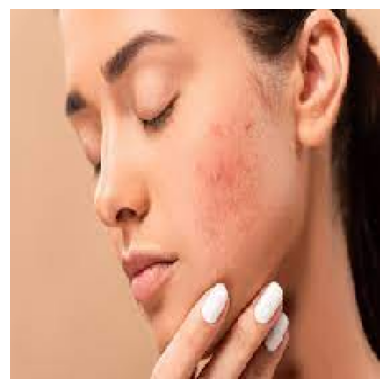

In [ ]:
image_path = "test01.jpeg"
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


real_predictions1 = model1.predict(img_array)
real_predictions2 = model2.predict(img_array)
real_combined_predictions = np.concatenate((real_predictions1, real_predictions2), axis=1)
real_stacked_predictions = stacked_model.predict(real_combined_predictions)
predicted_classes = real_stacked_predictions

print(predicted_classes)
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 20ms/step
[0]


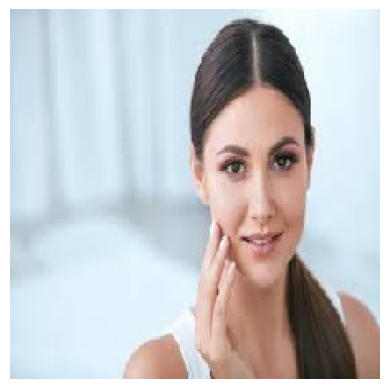

In [ ]:
image_path = "test0.jpeg"
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


real_predictions1 = model1.predict(img_array)
real_predictions2 = model2.predict(img_array)
real_combined_predictions = np.concatenate((real_predictions1, real_predictions2), axis=1)
real_stacked_predictions = stacked_model.predict(real_combined_predictions)
predicted_classes = real_stacked_predictions

print(predicted_classes)
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 22ms/step
[2]


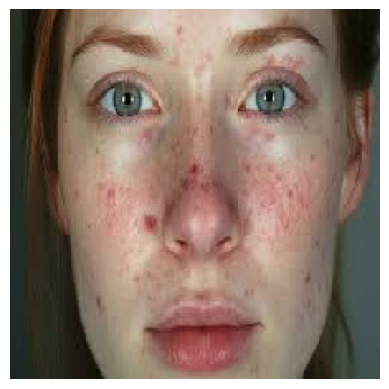

In [ ]:
image_path = "test02.jpeg"
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


real_predictions1 = model1.predict(img_array)
real_predictions2 = model2.predict(img_array)
real_combined_predictions = np.concatenate((real_predictions1, real_predictions2), axis=1)
real_stacked_predictions = stacked_model.predict(real_combined_predictions)
predicted_classes = real_stacked_predictions

print(predicted_classes)
plt.imshow(img)
plt.axis('off')
plt.show()